# Text classification 

In this notebook we show how to classify texts based on the presence of words into 34 different classes

## Imports

In [1]:
import glob
import pickle

import pandas as pd
from os.path import basename, join
from tqdm.auto import tqdm

from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sn
import matplotlib.pyplot as plt

## Load avalible file paths

In [2]:
tagger_name = "KRNNT"
name_keyword = ""

In [3]:
basedir = join("out_file")

paths = glob.glob(f"{basedir}/*.pkl")
paths = list(filter(lambda path: name_keyword not in path and "license" not in path, paths))
# paths = list(filter(lambda path: "morphodita" not in path and "clarin" not in path and "license" not in path, paths))

f"{len(paths)} files in the directory"

'6885 files in the directory'

## Count quantity of each noun, verb and adjective in every text

In [4]:
nouns = {}
verbs = {}
adjectives = {}

for path in paths:
    with open(path,'rb') as f:
        datafile = pickle.load(f)
        
        for key, value in datafile["noun"].items():
            try:
                nouns[key] += value
            except KeyError as e:
                nouns[key] = value
                
        for key, value in datafile["verb"].items():
            try:
                verbs[key] += value
            except KeyError as e:
                verbs[key] = value
                
        for key, value in datafile["adjective"].items():
            try:
                adjectives[key] += value
            except KeyError as e:
                adjectives[key] = value                

f"nouns: {len(nouns)}, verbs {len(verbs)}, adjectives {len(adjectives)}"

'nouns: 127089, verbs 7308, adjectives 18410'

## Narrow nouns verbs and adjectives to those with presence more frequent then threshold

In [5]:
quantity_threshold = 50

filtered_nouns = {key: value for key, value in nouns.items() if value>quantity_threshold}
filtered_verbs = {key: value for key, value in verbs.items() if value>quantity_threshold}
filtered_adjectives = {key: value for key, value in adjectives.items() if value>quantity_threshold}

f"nouns: {len(filtered_nouns)}, verbs {len(filtered_verbs)}, adjectives {len(filtered_adjectives)}"

'nouns: 2549, verbs 805, adjectives 920'

## Generate classnames

In [9]:
classes = set(sorted([basename("".join(filter(lambda x: not x.isdigit(), path))).replace(f"_-{name_keyword}.pkl", "") for path in paths]))
classes = set(sorted([basename("".join(filter(lambda x: not x.isdigit(), path))).replace(f"_{name_keyword}.pkl", "") for path in paths]))
f"{len(classes)} classes in the dataset"

'34 classes in the dataset'

## Check a presence of the most frequent words in every file

In [12]:
labels_for_all_examples = []
nouns_presence_in_all_examples = []
verbs_presence_in_all_examples = []
adjectives_presence_in_all_examples = []

for path in tqdm(paths):
    
    label = list(filter(lambda label: label in path, classes))[0]
    labels_for_all_examples.append(label)
    
    with open(path,'rb') as f:
        datafile = pickle.load(f)
        
        nouns_in_file = list(datafile["noun"].keys())
        verbs_in_file = list(datafile["verb"].keys())
        adjectives_in_file = list(datafile["adjective"].keys())
        
        nouns_presence_one_hot_list = list(map(lambda word: word in nouns_in_file, filtered_nouns))
        nouns_presence_in_all_examples.append(nouns_presence_one_hot_list) 
        
        verbs_presence_one_hot_list = list(map(lambda word: word in verbs_in_file, filtered_verbs))
        verbs_presence_in_all_examples.append(verbs_presence_one_hot_list) 
        
        adjectives_presence_one_hot_list = list(map(lambda word: word in adjectives_in_file, filtered_adjectives))
        adjectives_presence_in_all_examples.append(adjectives_presence_one_hot_list) 

## Generate dataframes

In [13]:
y_df = pd.DataFrame(data={"label": labels_for_all_examples})
y_df.head()

,label
0,Komiksy
1,Narciarstwo
2,Rachunkowosc
3,Rachunkowosc
4,Sporty-silowe


In [14]:
nouns_df = pd.DataFrame(nouns_presence_in_all_examples, columns=filtered_nouns.keys())
nouns_df.head()

,X,Men,seria,superbohater,grupa,scenariusz,John,rysunek,rok,nakład,...,Emilka,Żabon,kapturnik,absynt,spojówka,Rigby,Ahonen,madżong,HBV,Chii
0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [15]:
verbs_df = pd.DataFrame(verbs_presence_in_all_examples, columns=filtered_verbs.keys())
verbs_df.head()

,stworzyć,ukazywać,publikować,być,zdobyć,startować,wystąpić,zdobywać,wywalczyć,zajmować,...,opadać,zaokrąglić,promować,praktykować,zrzucać,proponować,złomować,zakazić,uplasować,uzupełnić
0,True,True,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [16]:
adjectives_df = pd.DataFrame(adjectives_presence_in_all_examples, columns=filtered_adjectives.keys())
adjectives_df.head()

,amerykański,komiksowy,2004,polski,główny,2006,dobry,niebezpieczny,2008,suchy,...,ligowy,wyścigowy,wirusowy,lubelski,powyższy,leczniczy,towarowy,cylindrowy,trałowy,wodorowy
0,True,True,True,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Classifiers

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB

### Nouns

In [18]:
X = nouns_df
y = y_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [19]:
model = BernoulliNB()

clf = model.fit(X_train, y_train)

f"Train accuracy: {accuracy_score(y_train, clf.predict(X_train))}, Test accracy: {accuracy_score(y_test, clf.predict(X_test))}"

/home/piotr/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


'Train accuracy: 0.7810457516339869, Test accracy: 0.7320261437908496'

In [20]:
print(classification_report(y_test, clf.predict(X_test), target_names=y.label.unique()))

                                   precision    recall  f1-score   support

                          Komiksy       0.46      0.88      0.61        42
                      Narciarstwo       0.92      0.87      0.89        39
                     Rachunkowosc       0.57      0.17      0.27        23
                    Sporty-silowe       0.90      0.66      0.76        41
                  Gry-komputerowe       0.94      0.73      0.82        44
            Pierwiastki-chemiczne       0.81      0.58      0.68        38
System-opieki-zdrowotnej-w-Polsce       0.68      0.90      0.78        42
                    Galezie-prawa       0.94      0.69      0.79        42
                           Monety       0.78      0.50      0.61        42
                            Zydzi       0.87      0.65      0.74        40
                   Muzyka-powazna       1.00      0.95      0.98        44
                           Optyka       0.65      0.72      0.68        43
                        

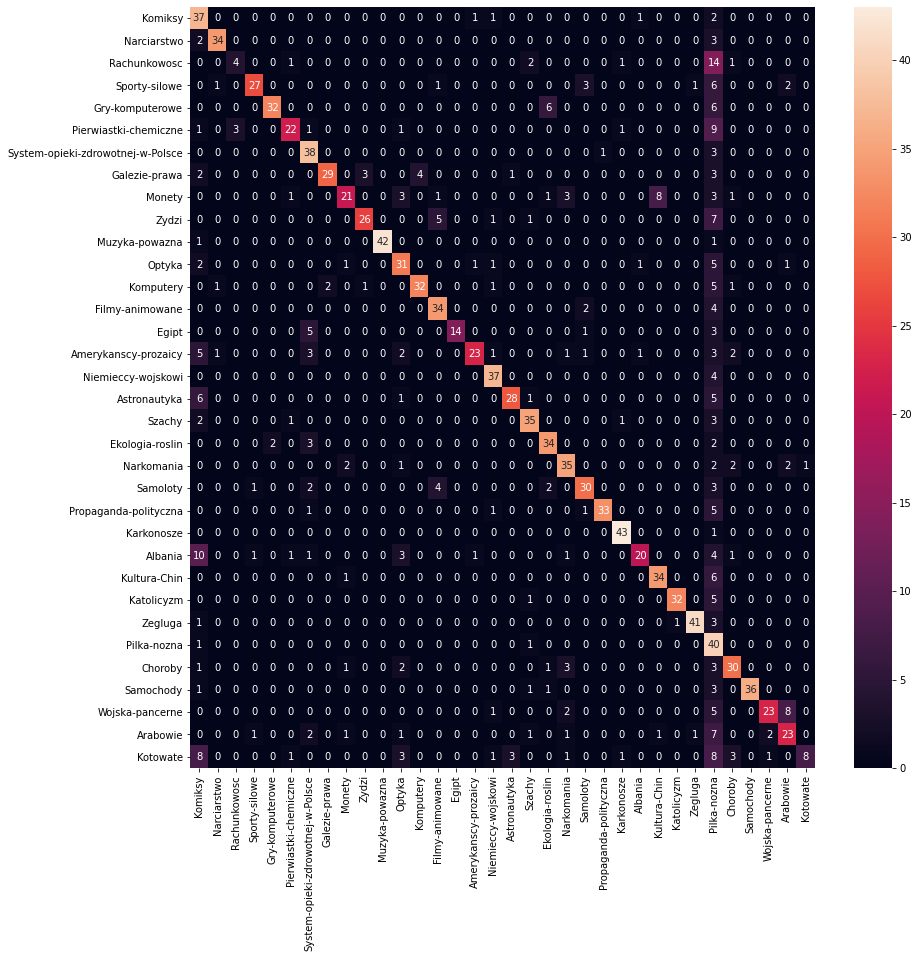

In [21]:
matrix = confusion_matrix(y_test, clf.predict(X_test))

df_cm = pd.DataFrame(matrix, index = y.label.unique(),
                  columns = y.label.unique())
plt.figure(figsize = (14,14))

sn_plot = sn.heatmap(df_cm, annot=True)
fig = sn_plot.get_figure()
fig.savefig(f"conf_matrix_noun_{tagger_name}.png")

### Verbs

In [22]:
X = verbs_df
y = y_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [23]:
model = BernoulliNB()

clf = model.fit(X_train, y_train)

f"Train accuracy: {accuracy_score(y_train, clf.predict(X_train))}, Test accracy: {accuracy_score(y_test, clf.predict(X_test))}"

/home/piotr/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


'Train accuracy: 0.5435729847494554, Test accracy: 0.4458968772694263'

In [24]:
print(classification_report(y_test, clf.predict(X_test), target_names=y.label.unique()))

                                   precision    recall  f1-score   support

                          Komiksy       0.36      0.48      0.41        42
                      Narciarstwo       0.49      0.54      0.51        39
                     Rachunkowosc       0.00      0.00      0.00        23
                    Sporty-silowe       0.64      0.44      0.52        41
                  Gry-komputerowe       0.79      0.59      0.68        44
            Pierwiastki-chemiczne       0.43      0.16      0.23        38
System-opieki-zdrowotnej-w-Polsce       0.49      0.60      0.54        42
                    Galezie-prawa       0.57      0.40      0.47        42
                           Monety       0.42      0.24      0.30        42
                            Zydzi       0.50      0.20      0.29        40
                   Muzyka-powazna       0.37      0.89      0.52        44
                           Optyka       0.36      0.23      0.28        43
                        

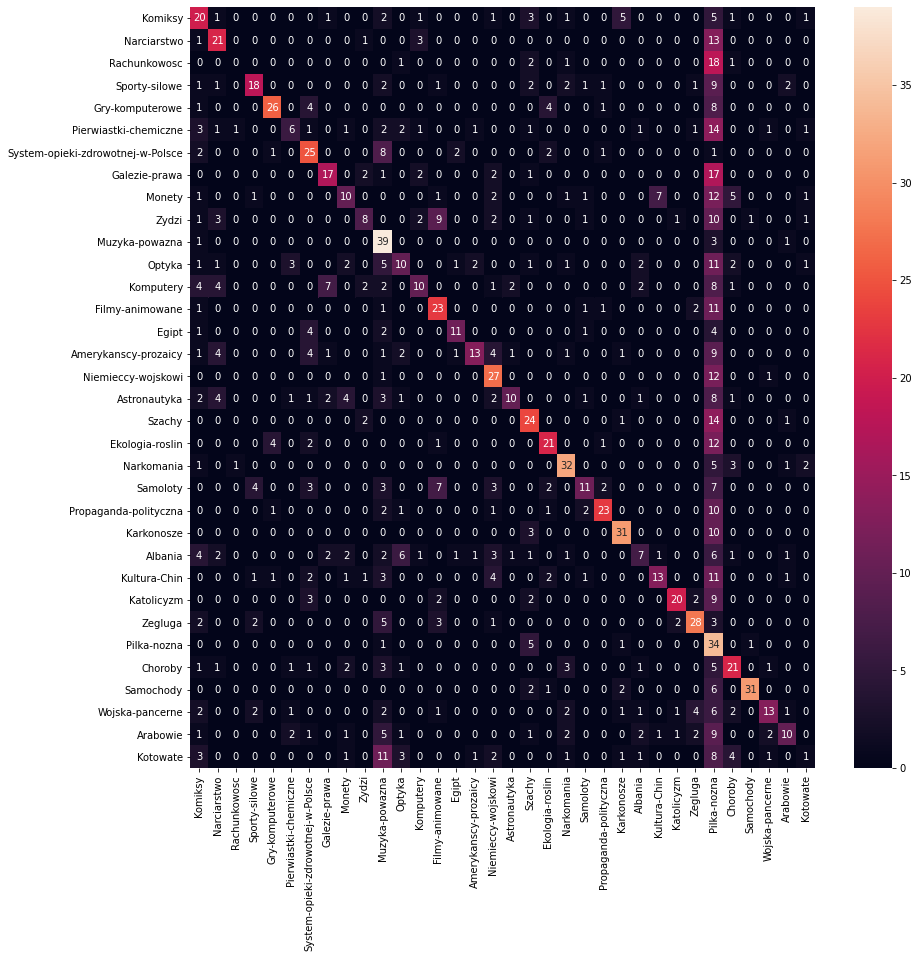

In [25]:
matrix = confusion_matrix(y_test, clf.predict(X_test))

df_cm = pd.DataFrame(matrix, index = y.label.unique(),
                  columns = y.label.unique())
plt.figure(figsize = (14,14))

sn_plot = sn.heatmap(df_cm, annot=True)
fig = sn_plot.get_figure()
fig.savefig(f"conf_matrix_verb_{tagger_name}.png")

### Adjectives

In [26]:
X = adjectives_df
y = y_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [27]:
model = BernoulliNB()

clf = model.fit(X_train, y_train)

f"Train accuracy: {accuracy_score(y_train, clf.predict(X_train))}, Test accracy: {accuracy_score(y_test, clf.predict(X_test))}"

/home/piotr/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


'Train accuracy: 0.6604938271604939, Test accracy: 0.6005809731299927'

In [28]:
print(classification_report(y_test, clf.predict(X_test), target_names=y.label.unique()))

                                   precision    recall  f1-score   support

                          Komiksy       0.49      0.67      0.57        42
                      Narciarstwo       0.71      0.64      0.68        39
                     Rachunkowosc       0.67      0.17      0.28        23
                    Sporty-silowe       0.83      0.49      0.62        41
                  Gry-komputerowe       0.92      0.52      0.67        44
            Pierwiastki-chemiczne       0.61      0.37      0.46        38
System-opieki-zdrowotnej-w-Polsce       0.54      0.79      0.64        42
                    Galezie-prawa       0.93      0.62      0.74        42
                           Monety       0.50      0.24      0.32        42
                            Zydzi       0.50      0.38      0.43        40
                   Muzyka-powazna       0.98      0.98      0.98        44
                           Optyka       0.69      0.58      0.63        43
                        

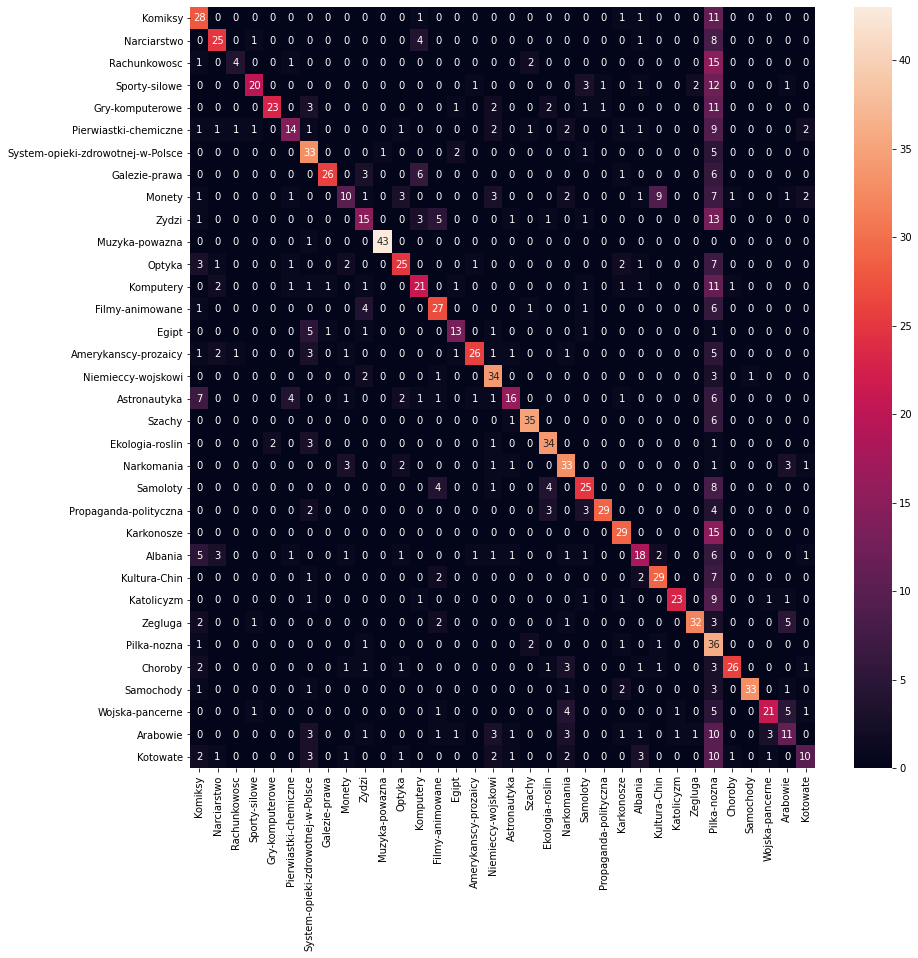

In [29]:
matrix = confusion_matrix(y_test, clf.predict(X_test))

df_cm = pd.DataFrame(matrix, index = y.label.unique(),
                  columns = y.label.unique())
plt.figure(figsize = (14,14))

sn_plot = sn.heatmap(df_cm, annot=True)
fig = sn_plot.get_figure()
fig.savefig(f"conf_matrix_adj_{tagger_name}.png")